array([[<Axes: title={'center': 'n_tokens'}>]], dtype=object)

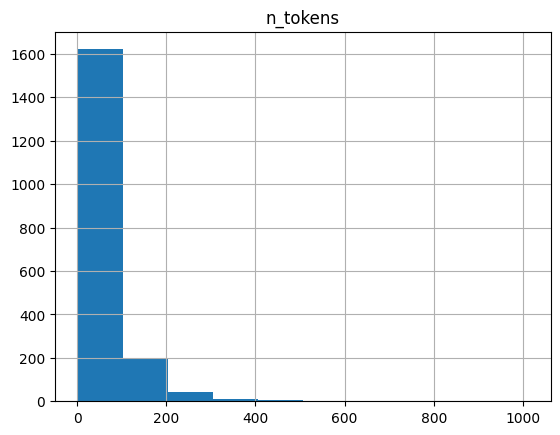

In [41]:
import numpy as np
import os
import pandas as pd
import gradio as gr
import matplotlib.pyplot as plt
import tiktoken
import openai
import time 
from openai.embeddings_utils import distances_from_embeddings, cosine_similarity



tokenizer = tiktoken.get_encoding("cl100k_base")

df = pd.read_csv('source.csv', header=None, names=['texto'])
df.columns = ['texto']

# Tokenize o texto e salve o número de tokens em uma nova coluna
df['n_tokens'] = df.texto.apply(lambda x: len(tokenizer.encode(x)))

# Visualize a distribuição do número de tokens por linha usando um histograma
df.hist(column='n_tokens')

In [42]:
df.head()

,texto,n_tokens
0,"Em 2024, teremos uma oportunidade única de esc...",125
1,É por isso que apresentamos este Programa elei...,143
2,"Acreditamos que a educação, a ciência e a cult...",120
3,"Acreditamos que a sustentabilidade, a agricult...",150
4,Acreditamos que a coesão territorial e a desce...,110


In [43]:
max_tokens = 2000

# Função para dividir o texto em partes de um número máximo de tokens
def split_into_many(texto, max_tokens = max_tokens):

    
    sentences = texto.split('. ')

  
    n_tokens = [len(tokenizer.encode(" " + sentence)) for sentence in sentences]
    
    chunks = []
    tokens_so_far = 0
    chunk = []

    
    for sentence, token in zip(sentences, n_tokens):

        if tokens_so_far + token > max_tokens:
            chunks.append(". ".join(chunk) + ".")
            chunk = []
            tokens_so_far = 0

        # Se o número de tokens na frase atual for maior que o número máximo de 
        # tokens, vá para a próxima sentença
        if token > max_tokens:
            continue

        # Caso contrário, adicione a frase ao bloco e adicione o número de tokens ao total
        chunk.append(sentence)
        tokens_so_far += token + 1

    return chunks
    

shortened = []

# Percorrer o dataframe
for row in df.iterrows():

    # Se o texto for None, vá para a próxima linha
    if row[1]['texto'] is None:
        continue

    # Se o número de tokens for maior que o número máximo de tokens, divida o texto em partes
    if row[1]['n_tokens'] > max_tokens:
        shortened += split_into_many(row[1]['texto'])
    
    # Caso contrário, adicione o texto à lista de textos abreviados
    else:
        shortened.append( row[1]['texto'] )

In [44]:
df.head()

,texto,n_tokens
0,"Em 2024, teremos uma oportunidade única de esc...",125
1,É por isso que apresentamos este Programa elei...,143
2,"Acreditamos que a educação, a ciência e a cult...",120
3,"Acreditamos que a sustentabilidade, a agricult...",150
4,Acreditamos que a coesão territorial e a desce...,110


array([[<Axes: title={'center': 'n_tokens'}>]], dtype=object)

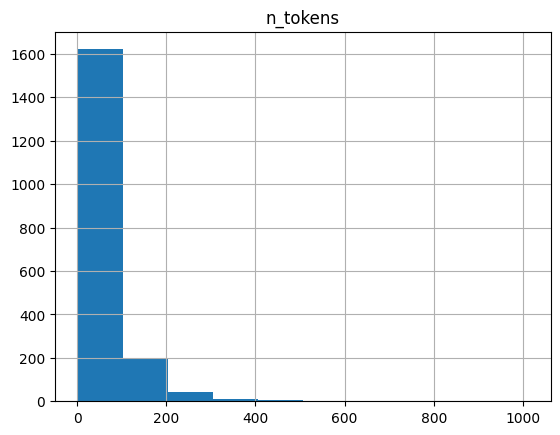

In [45]:
df = pd.DataFrame(shortened, columns = ['texto'])
df['n_tokens'] = df.texto.apply(lambda x: len(tokenizer.encode(x)))
df.hist(column='n_tokens')

In [46]:
num_tot_tokens = df['n_tokens'].sum()
print("Número total de tokens",num_tot_tokens)

Número total de tokens 113396


In [47]:
i = 0
for texto in df['texto']:
    i+=1
    
print("Número de trechos de texto com no máximo",max_tokens,"tokens :",i)

Número de trechos de texto com no máximo 2000 tokens : 1880


In [48]:
def read_openai_api_key():
    with open('openai_chave.txt', 'r') as file:
        api_key = file.read().strip()
    return api_key

my_api_key = read_openai_api_key()

In [12]:
openai.api_key = read_openai_api_key()

In [49]:
df.head()

,texto,n_tokens
0,"Em 2024, teremos uma oportunidade única de esc...",125
1,É por isso que apresentamos este Programa elei...,143
2,"Acreditamos que a educação, a ciência e a cult...",120
3,"Acreditamos que a sustentabilidade, a agricult...",150
4,Acreditamos que a coesão territorial e a desce...,110


In [ ]:
i = 0
embeddings = []
for tex in df['texto']:
    time.sleep(2)
    print(i)
    try:
        tex1 = tex.replace("\n", " ")
        embedding = openai.Embedding.create(input=tex1, engine='text-embedding-3-small')['data'][0]['embedding']
        print("Fazendo embedding do texto")
        embeddings.append(embedding)
    except openai.error.RateLimitError:
        print("Rate limit error, esperando 10 segundo antes de tentar novamente")
        time.sleep(20)  
        embedding = openai.Embedding(input=tex1, engine='text-embedding-3-small')['data'][0]['embedding']
        print("embedding texto depois de esperar 20 segundos")
        embeddings.append(embedding)
    i+=1

df['embeddings'] = embeddings
df.to_csv('embeddings.csv')
df.head()

In [51]:
df=pd.read_csv('embeddings.csv', index_col=0)
df['embeddings'] = df['embeddings'].apply(eval).apply(np.array)

df.head()

,texto,n_tokens,embeddings
0,"Em 2024, teremos uma oportunidade única de esc...",125,"[0.017937149852514267, 0.013401876203715801, 0..."
1,É por isso que apresentamos este Programa elei...,143,"[0.06237228959798813, 0.003158759092912078, 0...."
2,"Acreditamos que a educação, a ciência e a cult...",120,"[0.06579941511154175, -0.008490086533129215, 0..."
3,"Acreditamos que a sustentabilidade, a agricult...",150,"[0.048812080174684525, 0.03299587592482567, 0...."
4,Acreditamos que a coesão territorial e a desce...,110,"[0.044376570731401443, 0.029419563710689545, 0..."


In [52]:
def create_context(question, df, max_len=1800, size="ada"):
    """
    Cria um contexto para uma pergunta encontrando o contexto mais similar no conjunto de embeddings gerado utilizando o Custom Knowledge.
    """

    # Obter a embeddings para a pergunta que foi feita
    q_embeddings = openai.Embedding.create(input=question, engine='text-embedding-3-small')['data'][0]['embedding']

    # Obter as distâncias a partir dos embeddings
    df['distances'] = distances_from_embeddings(q_embeddings, df['embeddings'].values, distance_metric='cosine')


    returns = []
    cur_len = 0

    # Classifique por distância e adicione o texto ao contexto
    for i, row in df.sort_values('distances', ascending=True).iterrows():
        
        # Adicionar o comprimento do texto ao comprimento atual
        cur_len += row['n_tokens'] + 4
        
    
        if cur_len > max_len:
            break
        
        # Caso contrário, adicione-o ao texto que está sendo retornado
        returns.append(row["texto"])

    # Retornar o contexto
    return "\n\n###\n\n".join(returns)


In [ ]:
def answer_question(
                    df=df,
                    model="gpt-3.5-turbo-instruct",
                    question="O que é a Alianca Democratica?",
                    max_len=1800,
                    size="ada",
                    debug=False,
                    max_tokens=150,
                    stop_sequence=None):
    """
    Responder a uma pergunta com base no contexto mais semelhante dos textos do dataframe
    """
    context = create_context(question, df=df, max_len=max_len,size=size)
    if debug:
        print("Context:\n" + context)
        print("\n\n")

    try:
        # Criar uma conclusão usando a pergunta e o contexto
        response = openai.Completion.create(
            prompt=f"Responda as perguntas com base no contexto abaixo, e se a pergunta não puder ser respondida diga \"Eu não sei responder isso\"\n\Contexto: {context}\n\n---\n\nPergunta: {question}\nResposta:",
            temperature=0,
            max_tokens=max_tokens,
            top_p=1,
            frequency_penalty=0,
            presence_penalty=0,
            stop=stop_sequence,
            model=model
        )
        return response["choices"][0]["text"].strip()
    except Exception as e:
        print(e)
    #     retornar ""

In [54]:
answer_question(question="O que é a Alianca Democratica?", debug=False)

'A Aliança Democrática é uma coligação política formada pelos partidos PSD, CDS-PP e PPM, juntamente com personalidades independentes, que propõe uma mudança política e de políticas no país, com o objetivo de promover a prosperidade, o crescimento econômico e as oportunidades para todos os portugueses. Foi criada em 1979 e reeditada em 2024, com o objetivo de governar o país e superar o ciclo de governação socialista.'

In [55]:
def chatgpt_clone(input, history):
    history= history or []
    s = list(sum(history, ()))
    s.append(input)
    inp = ' '.join(s)
    output=answer_question(question = inp)
    history.append((input, output))
    return history, history

In [56]:
with gr.Blocks(theme=gr.themes.Soft(),css=".gradio-container {background-color: lightsteelblue}") as block:
    with gr.Row():
        img1 = gr.Image("images/ad.png",show_label=False, width=100, height=100)
        img2 = gr.Image("images/ad1.png",show_label=False, width=100, height=100)
    gr.Markdown("""<h1><center>Chatbot Aliança Democrática Grupo Nº 11 </center></h1>""")
    chatbot=gr.Chatbot(label="Conversa")
    message=gr.Textbox(label="Faça sua pergunta",placeholder="O que você gostaria de saber sobre Aliança Democrática?")
    state = gr.State()
    submit = gr.Button("Perguntar")
    submit.click(chatgpt_clone, inputs=[message, state], outputs=[chatbot, state])

block.launch(debug=True)

Running on local URL:  http://127.0.0.1:7860

To create a public link, set `share=True` in `launch()`.
